In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings('ignore')

# Load the dataset
# The data file is located in the parent directory
df = pd.read_csv('../ML471_S4_Datafile_Concept.csv')

# Display the first few rows
df.head()

,Datetime,Consumption,Festivals/Special_events,Power_Consumption_diff
0,1988-01-01,107.5052,6,NaN
1,1988-02-01,105.6720,1,-1.8332
2,1988-03-01,97.4502,1,-8.2218
3,1988-04-01,92.4714,1,-4.9788
4,1988-05-01,90.3151,1,-2.1563


In [2]:
# Preprocessing
if 'Datetime' in df.columns:
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)

# Check and remove missing values
print(f"Missing values before removal:\n{df.isnull().sum()}")
df = df.dropna(subset=['Consumption'])

# Split the dataset into training (80%) and testing (20%) sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print(f"\nTraining set size: {len(train)}")
print(f"Testing set size: {len(test)}")

Missing values before removal:
Consumption                 0
Festivals/Special_events    0
Power_Consumption_diff      1
dtype: int64

Training set size: 317
Testing set size: 80


In [3]:
# Define and fit the SARIMA model
# Model structure: SARIMA((1, 0, 2) × (0, 1, 1, 12))
# This includes Non-seasonal AR(1), MA(2), Seasonal Differencing(1), and Seasonal MA(1) at lag 12
sarima_model = SARIMAX(train['Consumption'], 
                       order=(1, 0, 2), 
                       seasonal_order=(0, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit(disp=False)

# Generate forecasts for the test period
forecast_obj = sarima_result.get_forecast(steps=len(test))
forecast_mean = forecast_obj.predicted_mean
forecast_mean.index = test.index

print(sarima_result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          Consumption   No. Observations:                  317
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                -644.448
Date:                              Mon, 02 Feb 2026   AIC                           1298.895
Time:                                      10:42:43   BIC                           1317.245
Sample:                                  01-01-1988   HQIC                          1306.247
                                       - 05-01-2014                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9954      0.003    311.492      0.000       0.989       1.002
ma.L1         -0.43

MAE: 2.8391
RMSE: 3.6259
MAPE: 2.0492%


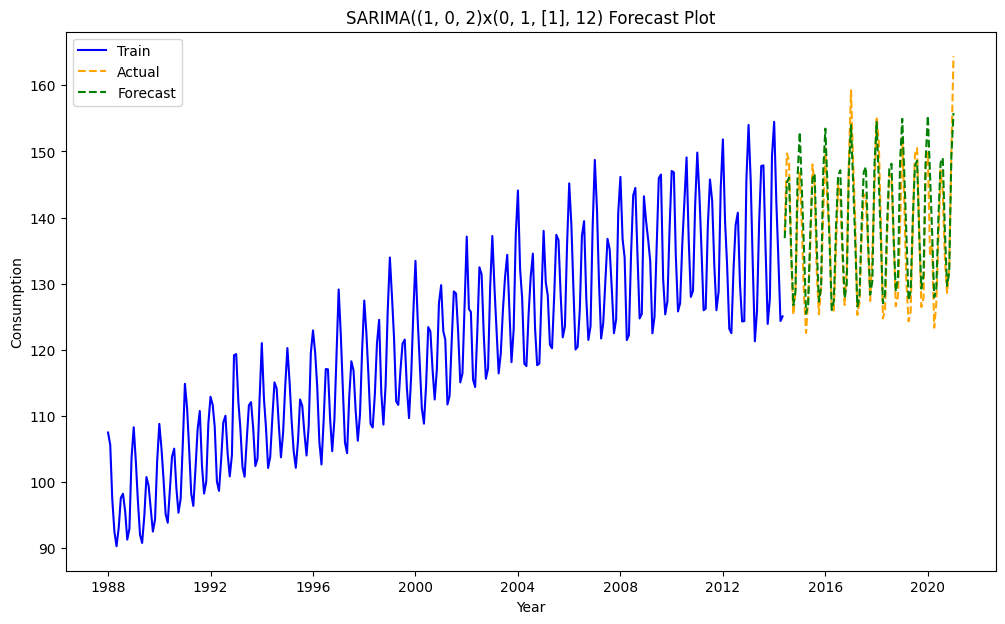

In [4]:
# Quantitative Assessment: Evaluation Metrics
mae = mean_absolute_error(test['Consumption'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test['Consumption'], forecast_mean))
mape = np.mean(np.abs((test['Consumption'] - forecast_mean) / test['Consumption'])) * 100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")

# Forecast Visualization
plt.figure(figsize=(12, 7))
plt.plot(train.index, train['Consumption'], label='Train', color='blue')
plt.plot(test.index, test['Consumption'], label='Actual', color='orange', linestyle='--')
plt.plot(test.index, forecast_mean, label='Forecast', color='green', linestyle='--')

plt.title('SARIMA((1, 0, 2)x(0, 1, [1], 12) Forecast Plot')
plt.xlabel('Year')
plt.ylabel('Consumption')
plt.legend()
plt.show()

Residual Diagnostics:


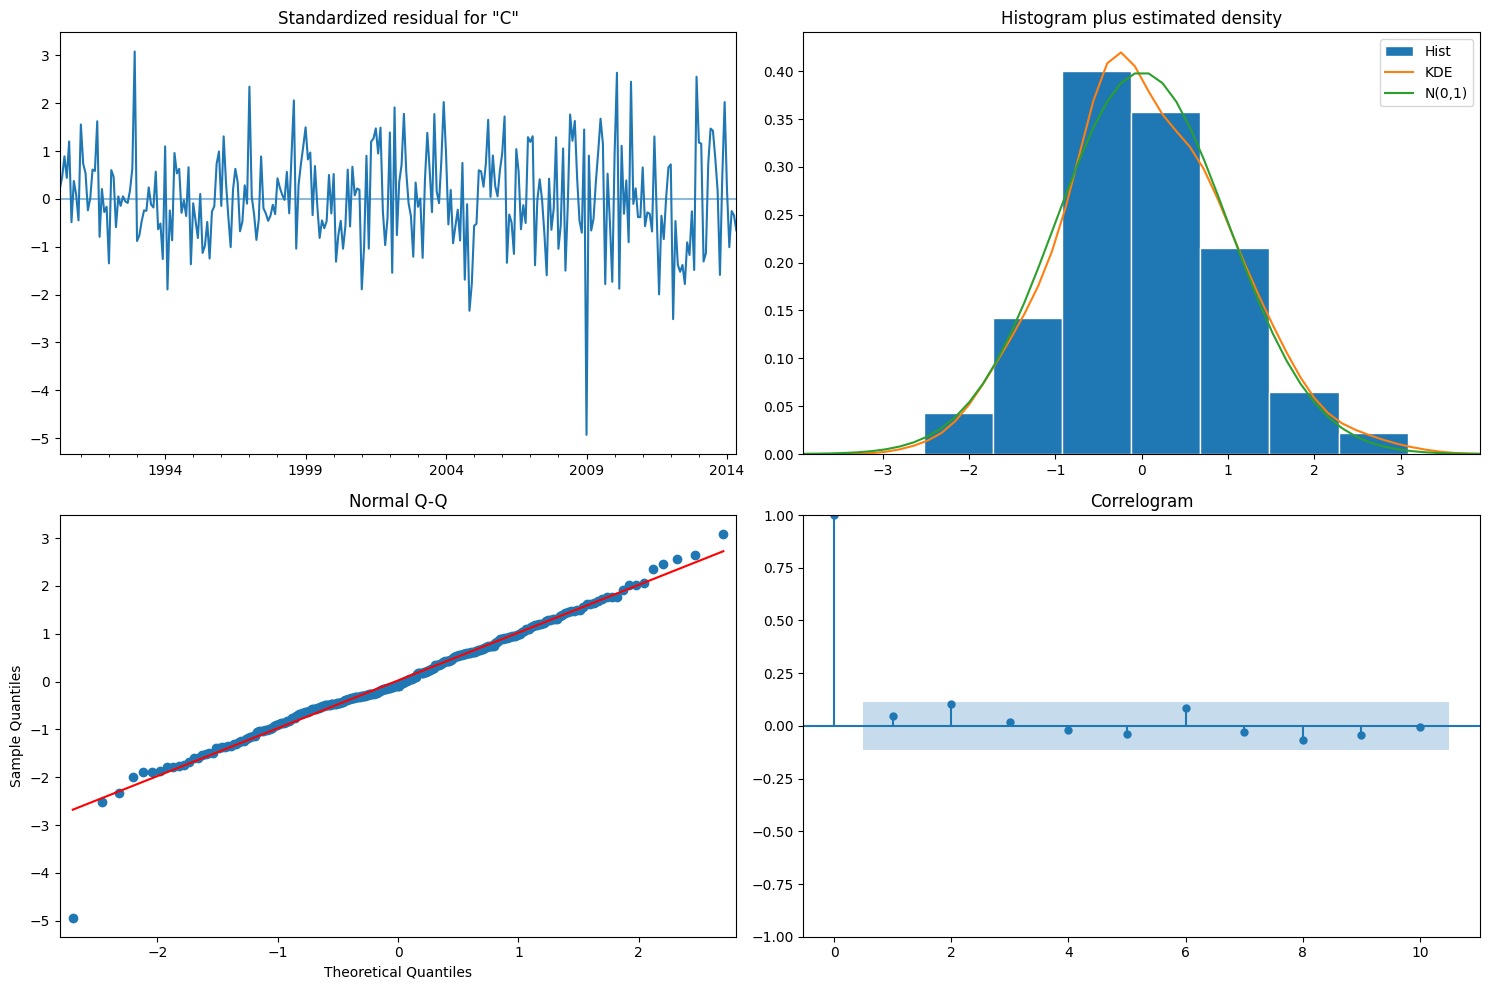

In [5]:
# Residual Analysis and Model Adequacy
print("Residual Diagnostics:")
sarima_result.plot_diagnostics(figsize=(15, 10))
plt.tight_layout()
plt.show()

# Conclusion
# The residual time plot shows random fluctuations around zero.
# The absence of significant autocorrelation in the ACF plot indicates that 
# the temporal dependencies are well-captured by the model.
